# Mandyoc: MANtle DYnamics simulatOr Code

*Mandyoc* is a finite element code written on top of the PETSc library to simulate thermo-chemical convection of the Earth’s mantle.
Different linear and non-linear rheologies can be adopted, appropriately simulating the strain and stress pattern in the Earth’s crust and mantle, both in extensional or collisional tectonics.

To simulate mantle thermochemical convection, we adopted the formulation for non-Newtonian fluids together with the Boussinesq approximation to solve the following equations of conservation of mass, momentum and energy:

$$u_{i,i} = 0$$

$$\sigma_{ij,j} + g_{i} \rho_{0}(1 - \alpha(T - T_{0})) = 0$$

$$\frac{\partial T}{\partial t} + u_{i} T_{,i} = \kappa T_{,ii} + \frac{H}{c_p} - \frac{\alpha T g u_{e}}{c_{p}}$$
  
where $u$ is the velocity in the $i$ direction, $g$ is the gravity acceleration, $\rho_{0}$ is the reference rock density at temperature $T_0$, $\alpha$ is the coefficient of volumetric expansion, $T$ is the temperature, $\kappa$ is the thermal diffusivity, $H$ is the rate of radiogenic heat per unit of mass, $c_{p}$ is the specific heat, $\delta_{ij}$ is the Kronecker delta, and $\sigma_{ij}$ is the stress tensor:
	
$$\sigma_{ij} = -P \delta_{ij} + \eta (u_{i,j} + u_{j,i})$$

where $P$ is the dynamic pressure and $\eta$ is the effective viscosity of the rock.

The equations of conservation of mass, momentum and energy are solved using the finite element method.
*Mandyoc* uses hexahedral elements for three dimensional grids and quadrilateral elements for two dimensional grids.
The mass and momentum equations subsection presents the numerical methods used to solve the mass and momentum equations and the energy equation subsection shows how an implicit formulation was used to solve the energy equation.

To simulate any scenario, the user **must** provide the parameter file `param.txt` and, if set, the necessary ASCII files with the initial temperature field, velocity field and/or the initial interfaces of the model.
The flowchart showing the steps *Mandyoc* takes to solve the equations of conservation of mass, momentum and energy.
	
<img src="img/mandyoc-scheme.png">
	

It shows that once the code starts running and the input files are read, *Mandyoc* uses the effective viscosity field $\eta$ to calculate the velocity field $u$ and checks if the convergence condition satisfies the tolerance $tol$ 

While the minimum tolerance is not reached, *Mandyoc* utilizes the Uzawa's method to iteratively calculate a new $u$ and $P$ fields.
The updated fields modify the viscosity field $\eta$, which in turn disturbs the velocity field again.
These fields are updated until tolerance is reached.

Additionally, the compositional factor $C$ is evaluated for an advection as:

$$\frac{\partial C}{\partial t} + u_{i}C_{,i} = 0$$

Its solution is calculated placing randomly a number of particles within each finite element of the mesh, which are displaced based on the adjacent node velocity values.
The individual value for each particle is obtained by linear interpolation of the node values.


# Showcase: Continental rift

This example simulates the evolution of divergent margins, taking into account the plastic rheology and the sin-rift geodynamics.

## Input files

There are a few ways to run this model. The one that will presented comes from the assumption that the geometry, temperature and velocity at the beginning of the simulaion are know in a reasonable fashion. Therefore, we must provide them as input files, which are: 
* an *interface file* with the boundary of the interfaces and their composition information 
* an *initial temperature file* with the initial temperature field
* and an *initial velocity file* with the initial velocity field

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

from functions import (
    thermal_diffusivity,
    load_time,
    load_data, 
    load_velocity,
    colors
)

The domain of the model comprises an area of 1600 x 300 km<sup>2</sup> that is discretized by elements of 1 x 1 km<sup>2</sup>.

In [42]:
lx, lz = 1600.0e3, 300.0e3

nx, nz = 1601, 301

The regular meshgrid can be easily created using:

In [43]:
x = np.linspace(0, lx, nx)
z = np.linspace(-lz, 0, nz)

xx, zz = np.meshgrid(x, z)

### Interface file

For this simulation, the domain is subdivided into a few lithologial units:
* asthenosphere, 
* lithospheric mantle, 
* weak seed,
* lower crust, 
* upper crust, and
* sticky air. 

Each one of them with different compositional (rheological) properties.

To simulate the free surface, the *sticky air* approach is adopted, which adds a 40 km thick layer with a relatively low viscosity compatible with the atmospheric air density.

Additionally, to ensure the nucleation of the rift at the center of the numerical domain, a *weak seed* is added within the lithospheric mantle with a constant initial strain of 0.3.

In [44]:
h_sair = 40.0e3

h_lower_crust = 20.0e3

h_upper_crust = 20.0e3

h_litho = 130.0e3

# Seed depth position under the crust: 
z_seed = 13.0e3

The differente lithologies can be expressed in a dictionary:

In [45]:
interfaces = {
    "litho": -np.ones(nx) * h_litho,  
    "seed_base": -np.ones(nx) * (z_seed + h_lower_crust + h_upper_crust),
    "seed_top": -np.ones(nx) * (z_seed + h_lower_crust + h_upper_crust),
    "lower_crust": -np.ones(nx) * (h_lower_crust + h_upper_crust),
    "upper_crust": -np.ones(nx) * h_upper_crust,
    "air": np.zeros(nx),      
}

In [46]:
for i in interfaces:
    interfaces[i] = interfaces[i] - h_sair

The considerations above result in the geomtry shown in the following plot:

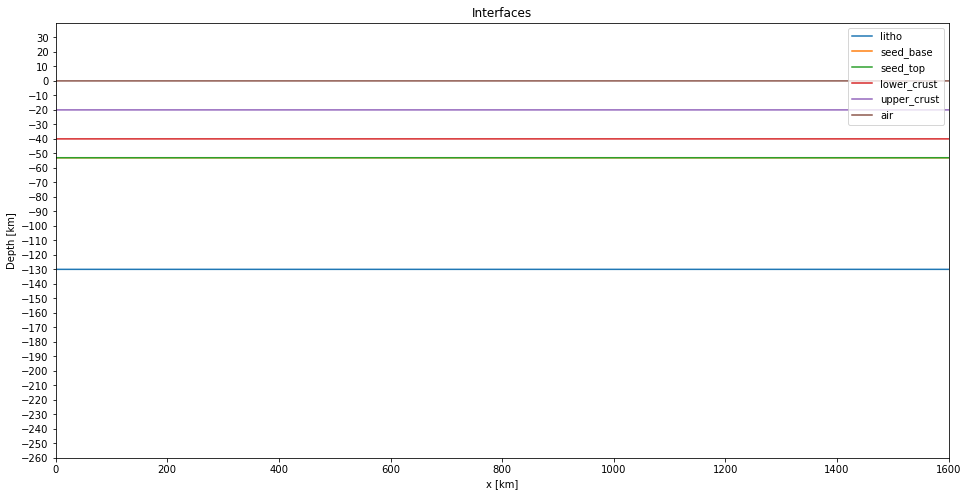

In [47]:
fig, ax = plt.subplots(figsize=(16, 8))

for label, layer in interfaces.items():
        ax.plot(x/1e3, (layer + h_sair)/1e3, label=f"{label}")

ax.set_yticks(np.arange((-lz + h_sair)/1e3, h_sair/1e3, 10))
ax.set_xlim([0, lx/1e3])
ax.set_ylim([(-lz + h_sair)/1e3, h_sair/1e3])
ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

plt.title("Interfaces")
plt.legend(loc='upper right')

plt.show()

The weak seed can be created:

In [48]:
# Seed horizontal position:
x_seed = 750.0e3
# Seed thickness:
h_seed = 6.0e3

In [49]:
d_x = lx / (nx - 1)

cond = (x_seed - d_x <= x) & (x < x_seed + d_x)

# Add a thickness in the seed layer:
interfaces["seed_base"][cond] = interfaces["seed_base"][cond] - h_seed//2

interfaces["seed_top"][cond] = interfaces["seed_top"][cond] + h_seed//2

Plot the interfaces:

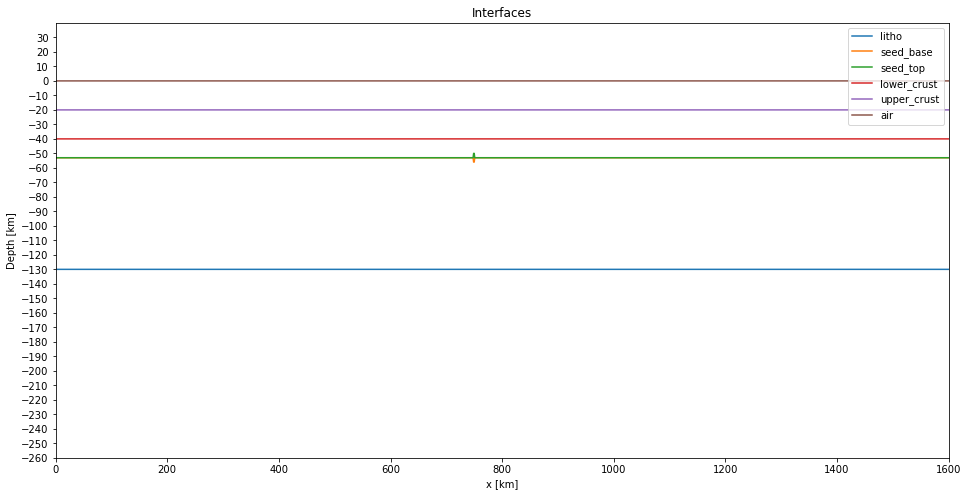

In [50]:
fig, ax = plt.subplots(figsize=(16, 8))

for label, layer in interfaces.items():
    ax.plot(x/1e3, (layer + h_sair)/1e3, label=f"{label}")

ax.set_yticks(np.arange((-lz + h_sair)/1e3, h_sair/1e3, 10))
ax.set_xlim([0, lx/1e3])
ax.set_ylim([(-lz + h_sair)/1e3, h_sair/1e3])
ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

plt.title("Interfaces")
plt.legend(loc='upper right')

plt.show()

Now we can create the interface file. 
This file contains the layers properties and the interface's depth between these layers.
The layer properties are:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (V)

We adopted a visco-plastic rheology where the effective viscosity $\eta$ combines nonlinear power law viscous rheology and a plastic yield criterion.
The viscous component is given by:

$$\eta_{visc} = C A^{-1/n} \dot{\varepsilon}^{(1-n)/n} \exp{\frac{Q + V P}{n R T}}$$

|     |               | Asthenosphere | Litho mantle | Seed       | Litho mantle over the seed | Lower crust | Upper crust | Air     |
| --- | ------------- | ------------- | ------------ | ---------- | -------------------------- | ----------- | ----------- | ------- |
| C   | -             | 1.0           | 1.0          | 0.1        | 1.0                        | 1.0         | 1.0         | 1.0     |
| rho | $$kg/m³$$     | 3378.0        | 3354.0       | 3354.0     | 3354.0                     | 2800.0      | 2700.0      | 1.0     |
| H   | $$W/kg$$      | 0.0           | 9.0e-12      | 9.0e-12    | 9.0e-12                    | Hlc         |  Huc        | 0.0     |
| A   | $$Pa^{-n}/s$$ | 1.393e-14     | 2.4168e-15   | 2.4168e-15 | 2.4168e-15                 | 8.574e-28   | 8.574e-28   | 1.0e-18 |
| n   | -             | 3.0           | 3.5          | 3.5        | 3.5                        | 4.0         | 4.0         | 1.0     |
| Q   | $$kJ/mol$$    | 429.0e3       | 540.0e3      | 540.0e3    | 540.0e3                    | 222.0e3     | 222.0e3     | 0.0     |
| V   | $$m³/mol$$    | 15.0e-6       | 25.0e-6      | 25.0e-6    | 25.0e-6                    | 0.0         | 0.0         | 0.0     |



In [51]:
# Define the density and the radiogenic heat for the upper and lower crust:
rho_uc = 2700.0
rho_lc = 2800.0
Huc = 2.5e-6 / rho_uc
Hlc = 0.8e-6 / rho_lc

In [52]:
# Define the layer properties:
layer_properties = f""" 
        C   1.0       1.0        0.1        1.0        1.0         1.0         1.0
        rho 3378.0    3354.0     3354.0     3354.0     {rho_lc}    {rho_uc}    1.0
        H   0.0       9.0e-12    9.0e-12    9.0e-12    {Hlc}       {Huc}       0.0
        A   1.393e-14 2.4168e-15 2.4168e-15 2.4168e-15 8.574e-28   8.574e-28   1.0e-18
        n   3.0       3.5        3.5        3.5        4.0         4.0         1.0
        Q   429.0e3   540.0e3    540.0e3    540.0e3    222.0e3     222.0e3     0.0
        V   15.0e-6   25.0e-6    25.0e-6    25.0e-6    0.0         0.0         0.0
    """

In [53]:
# Create and save the interface file:
with open("interfaces.txt", "w") as f:
    # Write the layer properties
    for line in layer_properties.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

    # Write the interfaces of the layers adding the thickness of the sticky air layer:
    data = np.array(tuple(interfaces.values())).T
    np.savetxt(f, data, fmt="%.1f")

### Initial temperature file

The initial temperature structure is depth dependent and is 0°C at the surface and 1300°C at the base of the lithosphere at 130 km.
With these boundary conditions, the initial temperature structure in the interior of the lithosphere is given by the solution of *thermal diffusivity* equation:

$$ \kappa \frac{\partial^2 T(z)}{\partial z^2} + \frac{H(z)}{c_p} = 0$$

where $H(z)$ is the internal heat production of the different layers.

The sublithospheric temperature follows an *adiabatic* increase up to the bottom of the model:

$$T = T_p \exp{\frac{g \alpha z}{c_p}}$$

Where $T_p$ is the potential temperature for the mantle, $g$ is the gravity value, $\alpha$ is the volumetric expansion coefficient, $c_p$ is the specific heat capacity.

* $\kappa = 1x10^{-6}$ $m²/s$
* $c_p = 1250$ $J kg^{-1} K^{-1}$
* $T_p = 1262$ °C
* $g = -10$ $m/s²$
* $\alpha = 3.28x10^{-5}$ $K^{-1}$

In [54]:
kappa = 1.0e-6
ccapacity = 1250
tem_p = 1262
g = -10
alpha = 3.28e-5

In [55]:
# Temperature when z is over 130 km:
temp_z = 1300 * (-z - h_sair) / (h_litho)

# Sublithospheric temperature:
temp_adiabatic = tem_p / np.exp(g * alpha * (-z - h_sair) / ccapacity)

# T = 0 when z is over zero:
temp_z[temp_z < 0.0] = 0.0

# When z is below 130 km (Lithosperic depth), the T = temp_adiabatic:
temp_z[temp_z > temp_adiabatic] = temp_adiabatic[temp_z > temp_adiabatic]

Now, we will apply the thermal diffusivity in the model.
First, create the internal heat production model:

In [56]:
H = np.zeros_like(temp_z)

# Add the H value for the upper crust:
cond = (z <= interfaces["air"][0]) & (z > interfaces["upper_crust"][0])
H[cond] = Huc

# Add the H value for the lower crust:
cond = (z <= interfaces["upper_crust"][0]) & (z > interfaces["lower_crust"][0])
H[cond] = Hlc

Apply the thermal diffusivity during 10 thousand years:

In [57]:
dt = 10000
dz = lz / (nz - 1)

# Apply the thermal diffusivity
temp_z = thermal_diffusivity(
    temp_z,
    z,
    interfaces, 
    H, 
    dt, 
    dz,
    kappa, 
    ccapacity
)

In [58]:
temp_z = np.ones_like(xx) * temp_z[:, None]

print(np.shape(temp_z))

# Save the initial temperature file
np.savetxt(
    "input_temperature_0.txt", 
    np.reshape(temp_z, (nx * nz)), 
    header="T1\nT2\nT3\nT4"
)

(301, 1601)


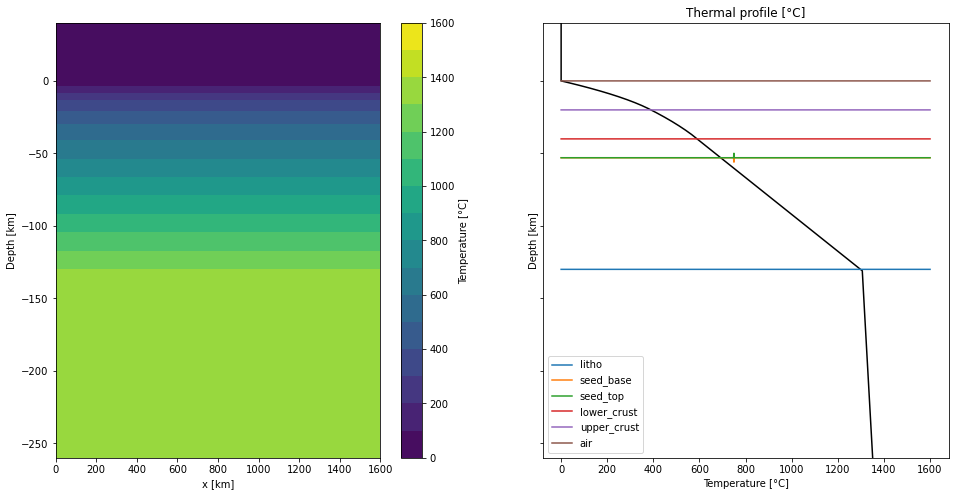

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

# Plot temperature field:
img_temp = axs[0].contourf(
    xx/1.0e3,
    (zz + h_sair)/1.0e3,
    temp_z,
    levels=np.arange(0, 1610, 100)
    )
cbar = fig.colorbar(img_temp, orientation='vertical', ax=axs[0])
cbar.set_label("Temperature [°C]")

axs[0].set_ylim([(-lz + h_sair)/1e3, h_sair/1e3])
axs[0].set_ylabel("Depth [km]")
axs[0].set_xlabel("x [km]")


# Plot temperature profile:
axs[1].set_title("Thermal profile [°C]")
axs[1].plot(temp_z[:, 0], (z + h_sair)/1.0e3, "-k")
# Add interfaces:
for label, layer in interfaces.items():
    axs[1].plot(x/1e3, (layer + h_sair)/1e3, label=f"{label}")

axs[1].set_ylim([(-lz + h_sair)/1e3, h_sair/1e3])
axs[1].set_xlabel("Temperature [°C]")
axs[1].set_ylabel("Depth [km]")
plt.legend(loc="lower left")

plt.show()

### Initial velocity field

The velocity field simulates the lithospheric stretching assuming a reference frame fixed on the lithospheric plate on the left side of the model. Thus, the plate on the right side moves rightward with a velocity of $v_{rift} = 1$ cm/year.
The velocity field in the left and right boundaries of the model are set to ensure conservation of mass and are symmetrical for the adopted reference frame that moves to the right with a velocity of $v_{rift}/2$ cm/year relative to the left plate.
The inflow on the vertical boundaries below the lithosphere compensates for outflow.

So, the horizontal velocity field along the left and right borders of the domain are:

$$
velocity_x(x = 0) = \left\{ 
    \begin{array}{rl}
        0, & \text{$z > -h_c - h_{sair}$} \\
        -v \frac{z + h_c + h_{sair}}{h_a}, & \text{$z \leq -h_c - h_{sair}$} 
    \end{array}
\right.
$$

$$
velocity_x(x = lx) = \left\{ 
    \begin{array}{rl}
        0, & \text{$z > h_{sair}$} \\
        v_{rift}, & \text{$z > -h_c - h_{sair}$} \\
        v \frac{z + h_c + h_{sair}}{h_a} + v_{rift}, & \text{$z \leq -h_c - h_{sair}$} 
    \end{array}
\right.
$$

where $v = v_{rift} \frac{lz - h_{sair}}{h_a}$ so that: 
$$
\int^{0}_{-lz} velocity_x(x = 0) = \int^{0}_{-lz} velocity_x(x = lx) = \frac{v h_a}{2} 
$$

where, finally, $h_c = 150$ km is the thickness of the upper layer with constant velocity, corresponding to the lithosphere $h_{litho} = 130$ km and 20 km of the asthenosphere and $h_a = lz - h_c - h_{sair}$

In [60]:
# Converting 1 cm/year to m/s:
v_rift = 1e-2 / (365 * 24 * 3600)
h_c= 150.0e3
h_a = lz - h_sair - h_c
v = v_rift * (lz - h_sair) / h_a

In [61]:
# Creating horizontal and vertical velocity:
velocity_xx, velocity_zz = np.zeros_like(xx), np.zeros_like(xx)

Velocity for the left side (x == 0):

In [62]:
cond = (xx == 0) & (zz <= -h_c - h_sair)
velocity_xx[cond] += -v * (zz[cond] + h_c + h_sair) / h_a

Velocity for the rigth side (x == lx):

In [63]:
cond = (xx == lx) & (zz > -h_c - h_sair)
velocity_xx[cond] += v_rift

cond = (xx == lx)& (zz <= -h_c - h_sair)
velocity_xx[cond] += v * (zz[cond] + h_c + h_sair) / h_a + v_rift

# Considering the first 10 km of air to have a constant velocity:
frac_air = 10e3
velocity_xx[zz >= -h_sair + frac_air] = 0

Respecting mass conservation, the sum of the integrals on the boundaries (material flow) must be zero.

In [64]:
# For the left side:
v0 = velocity_xx[xx == 0]
sum_velocity_left = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0

# For the right side:
vf = velocity_xx[(xx == lx)]
sum_velocity_right = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0

diff = (sum_velocity_right - sum_velocity_left) * dz

print("Sum of the integrals over the boundary is:", diff)

Sum of the integrals over the boundary is: 3.012430238457634e-06


When the sum of the integrals on the boundaries is not zero due to rounding errors, we add the difference back on the top to compensate make it zero. Despite not being negligeble, this is reasonable because it is a very small correction.

In [65]:
velocity_zz[zz == 0] = -diff / lx

Plot the velocity: 

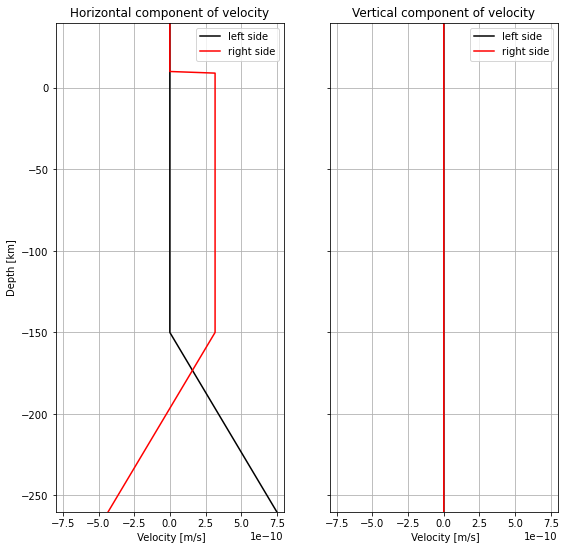

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 9), sharey=True)

# Plot horizontal component:
axs[0].plot(velocity_xx[:, 0], (z + h_sair)/1e3, "k-", label="left side")
axs[0].plot(velocity_xx[:, -1], (z + h_sair)/1e3, "r-", label="right side")

axs[0].legend()
axs[0].grid()
axs[0].set_ylim([(-lz + h_sair)/1e3 , h_sair/1e3])
axs[0].set_xlim([-8e-10, 8e-10])
axs[0].set_xlabel(" Velocity [m/s]")
axs[0].set_ylabel("Depth [km]")
axs[0].set_title("Horizontal component of velocity")


# Plot vertical component
axs[1].plot(velocity_zz[:, 0], (z + h_sair)/1e3, "k-", label="left side")
axs[1].plot(velocity_zz[:, -1], (z + h_sair)/1e3, "r-", label="right side")

axs[1].legend()
axs[1].grid()
axs[1].set_xlim([-8e-10, 8e-10])
axs[1].set_xlabel(" Velocity [m/s]")
axs[1].set_title("Vertical component of velocity")

plt.show()

Create and save the initial velocity file:

In [67]:
velocity = np.zeros((2, nx * nz))

velocity[0, :] = np.copy(np.reshape(velocity_xx, nx * nz))
velocity[1, :] = np.copy(np.reshape(velocity_zz, nx * nz))

velocity = np.reshape(velocity.T, (np.size(velocity)))

np.savetxt("input_velocity_0.txt", velocity, header="v1\nv2\nv3\nv4")

### Create the parameter file

The parameter file contains the information that is necessary for the simulation to run.
There are many parameters to define, so we will only show/discuss some of the important ones for this simulation. 
But I invite you to visit the *Mandyoc* documentation website to know more about the parameter file. 

* Define the number of Lagrangian particles in each element, *particles_per_element = 40*. 

* Specify the maximum time step and time of the simulation with *step_max = 5000* and *time_max = 100.0e6* (100 My).

* For the temperature boundary conditions, the temperature values is fixed on all sides during the simulation, with the nodes of the model in the air maintained at 0°C.
 
* For the velocity boundary conditions, free slip is applied on the top and bottom of the numerical domain. 

* To avoid a symmetric, laterally homogeneous model, we introduced a random perturbation of the initial strain in each finite element of the model. 

* Set the pre-defined rheology model to be used during simulation. In this case: *rheology_model = 9* 

In [68]:
params = f"""
# Geometry
nx                                  = {nx}          # n. of nodes in the horizontal direction
nz                                  = {nz}          # n. of nodes in the vertical direction
lx                                  = {lx}          # extent in the horizontal direction
lz                                  = {lz}          # extent in the vertical direction

# Simulation options
denok                               = 1.0e-15       # tolerance criterion for the Uzawa's scheme, default is 1.0e-4
Xi_min                              = 1.0e-7        # tolerance criterion for the convergence of the non-linear flow, default is 1.0e-14
random_initial_strain               = 0.3           # non-dimensional value for the initial strain perturbation for the entire domain, default is 0.0 
initial_dynamic_range               = True          # method to smoothen convergence of the velocity field in scenarios with wide viscosity range, default is False [True/False], Gerya (2019)
                         
# Particles options
particles_per_element               = 40            # n. of Lagrangian particles in each element, default is 81
particles_perturb_factor            = 0.7           # indicates the amount of perturbation of the initial location of the particles relative to a regular grid distribution. Default is 0.5 [values are between 0 and 1]

# Time constrains
step_max                            = 5000          # maximum time-step of the simulation [steps]
time_max                            = 100.0e6       # maximum time of the simulation [years]
dt_max                              = 10.0e6        # maximum time between steps of the simulation [years]
step_print                          = 10            # make output files every <step_print>
sub_division_time_step              = 0.5           # re-scale value for the calculated time-step, default is 1.0

# Viscosity
viscosity_reference                 = 1.0e26        # reference mantle viscosity [Pa.s]
viscosity_max                       = 1.0e25        # maximum viscosity during simulation [Pa.s]
viscosity_min                       = 1.0e18        # minimum viscosity during simulation [Pa.s]
viscosity_per_element               = constant      # sets if viscosity is constant or linearly variable for every element, default is variable [constant/variable]
viscosity_mean_method               = arithmetic    # defines method do calculate the viscosity for each element, default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # defines if viscosity depends on pressure or depth, default is depth [pressure/depth]
 
# External ASCII inputs/outputs
interfaces_from_ascii               = True          # set if interfaces between lithologies are read from an ASCII file (interfaces.txt), default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}            # set the number of interfaces to be read from the interfaces ASCII file (interfaces.txt) 
temperature_from_ascii              = True          # set if initial temperature is read from an ASCII file (input_temperature_0.txt), default is False [True/False]
velocity_from_ascii                 = True          # set if initial velocity field is read from an ASCII file (input_velocity_0.txt), default is False [True/False]
variable_bcv                        = False         # allows velocity field re-scaling through time according to an ASCII file (scale_bcv.txt), default is False [True/False]
multi_velocity                      = False         # set if boundary velocities can change with time from ASCII file(s) (multi_veloc.txt and additional input_velocity_[X].txt files), default is False [True/False]
binary_output                       = False         # set if output is in binary format, default is False [True/False]
print_step_files                    = True          # set if the particles position are printed to an output file, default is True [True/False]

sticky_blanket_air                  = True          # default is False [True/False]
precipitation_profile_from_ascii    = False         # default is False [True/False]
climate_change_from_ascii           = False         # default is False [True/False]

# Physical parameters
temperature_difference              = 1500.         # temperature difference between the top and bottom of the model (relevant if <temperature_from_ascii> is False) [K]
thermal_expansion_coefficient       = 3.28e-5       # value for the coefficient of thermal expansion [1/K]
thermal_diffusivity_coefficient     = 1.0e-6        # value for the coefficient of thermal diffusivity [m^2/s]
gravity_acceleration                = 10.0          # value for the gravity acceleration [m/s^2]
density_mantle                      = 3300.         # value for the mantle reference density [kg/m^3]
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250.         # value for the heat capacity [J/K]

non_linear_method                   = on            # set if non linear method is used for the momentum equation [on/off]
adiabatic_component                 = on            # set if adiabatic heating/cooling is active [on/off]
radiogenic_component                = on            # set if radiogenic heating is active [on/off]

# Velocity boundary conditions
top_normal_velocity                 = fixed         # set the normal velocity on the top side of the model to be fixed or free [fixed/free] 
top_tangential_velocity             = free          # set the tangential velocity on the top side of the model to be fixed or free [fixed/free]
bot_normal_velocity                 = fixed         # set the normal velocity on the bottom side of the model to be fixed or free [fixed/free]
bot_tangential_velocity             = free          # set the tangential velocity on the bot side of the model to be fixed or free [fixed/free]
left_normal_velocity                = fixed         # set the normal velocity on the left side of the model to be fixed or free [fixed/free]
left_tangential_velocity            = fixed         # set the tangential velocity on the left side of the model to be fixed or free [fixed/free]
right_normal_velocity               = fixed         # set the normal velocity on the right side of the model to be fixed or free [fixed/free]
right_tangential_velocity           = fixed         # set the tangential velocity on the right side of the model to be fixed or free [fixed/free]

surface_velocity                    = 0.0e-2        # ok

# Temperature boundary conditions
top_temperature                     = fixed         # set temperature on the top side of the model to be fixed or free [fixed/free]
bot_temperature                     = fixed         # set temperature on the bottom side of the model to be fixed or free [fixed/free]
left_temperature                    = fixed         # set temperature on the left side of the model to be fixed or free [fixed/free]
right_temperature                   = fixed         # set temperature on the right side of the model to be fixed or free [fixed/free]

rheology_model                      = 9             # flag n. of a pre-defined rheology model to use during simulation
"""

# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

## Run the model

In this example, mandyoc use the following flags:
```
-seed 0,2
-strain_seed 0.0,1.0
```

You can run the model as:
```
mpirun -n NUMBER_OF_CORES mandyoc -seed 0,2 -strain_seed 0.0,1.0
```
Where the NUMBER_OF_CORES value must be set by the user.

**This process took around 2 days to finish the temporal evolution.**

## Post-processing

After Mandyoc finished running the model, different files are obtained with the temporal evolution of the model as it was specified in the parameter file.
In this case, we are only going to use the density, cumulative strain, temperature, velocity, viscosity and density files.

### Plot the results

Now, we will plot the Mandyoc output file for only 5 different steps times. 
These file are into `output/` directory.

Determine the initial and final step to make the plots:

In [69]:
step_initial = 0
step_final = 5000

d_step = 1000

The dark and light orange colors represent the upper and lower crust, respectively, while the dark and light green colors represent lithospheric and sublithospheric mantle, respectively.
Shades of gray indicate the magnitude of the cumulative strain.
The blue and orange bars indicate the width of the extended continental crust in both conjugate margins.

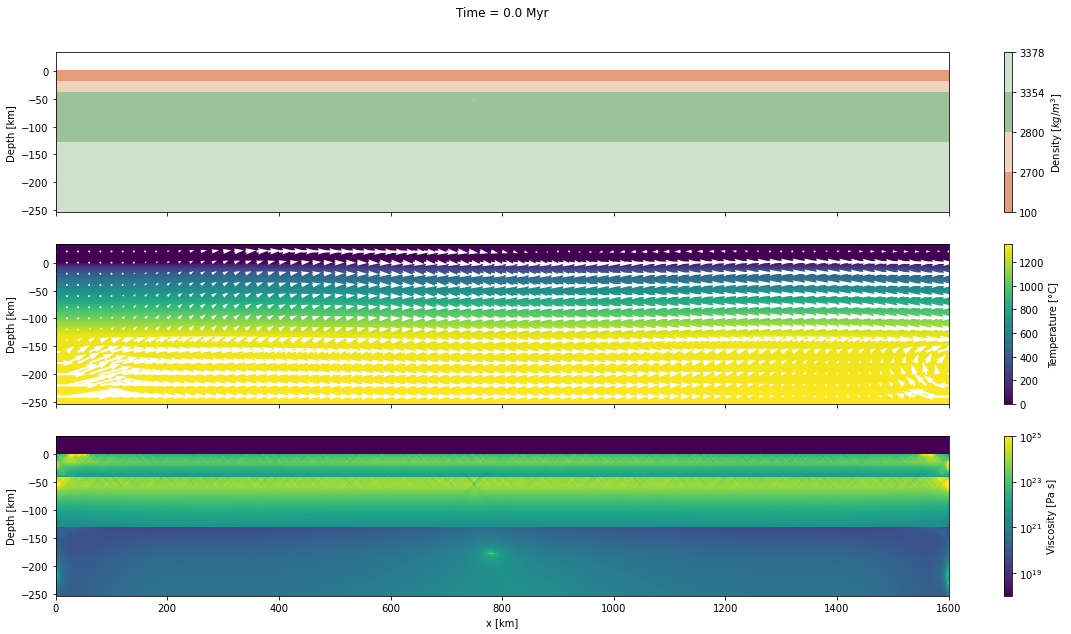

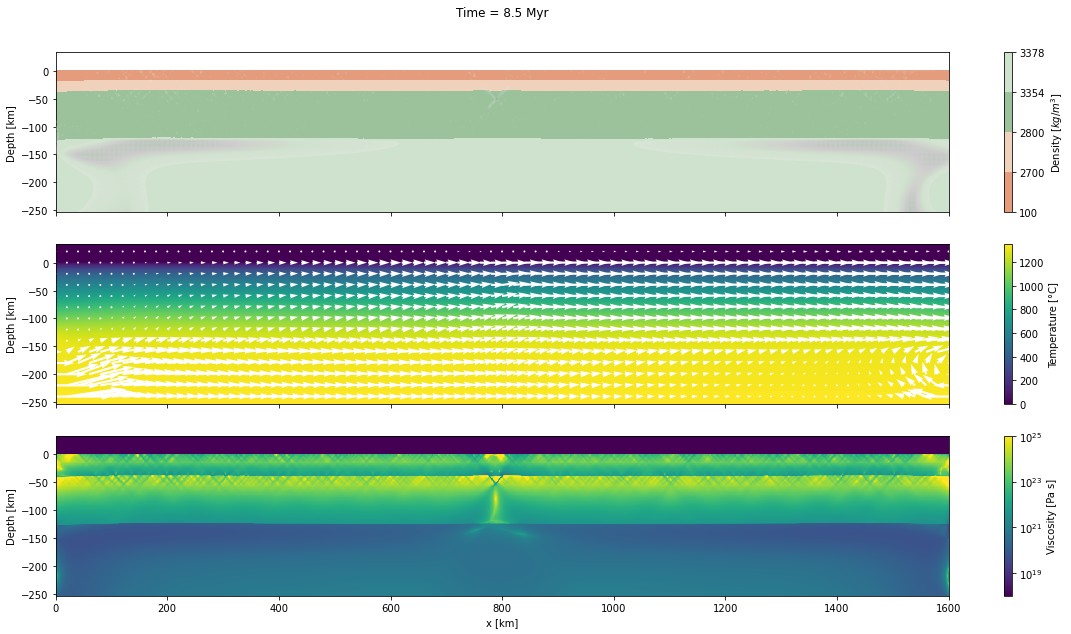

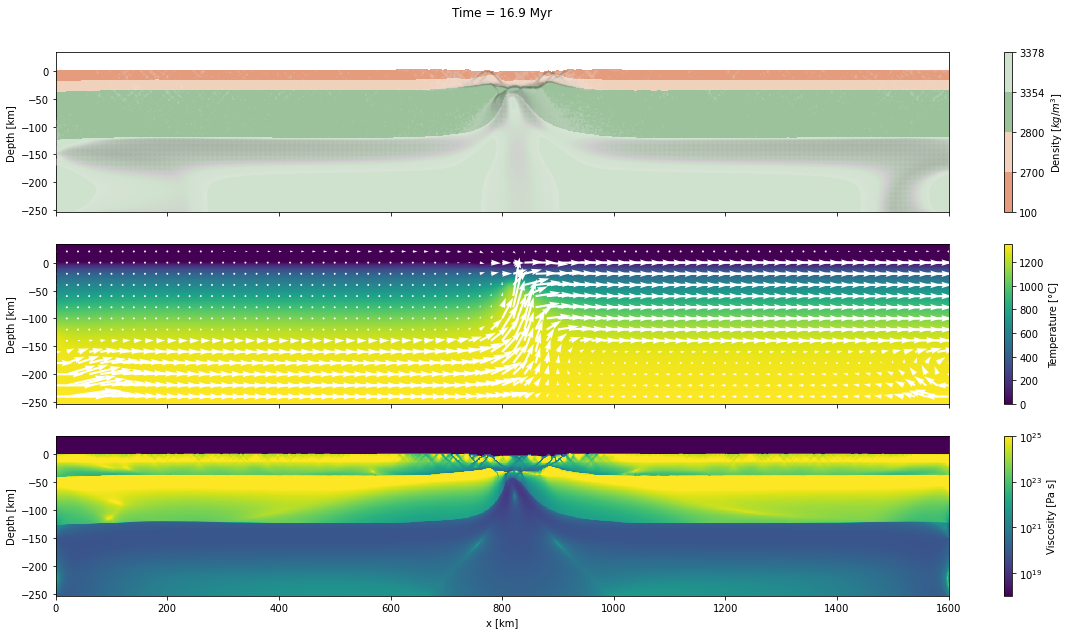

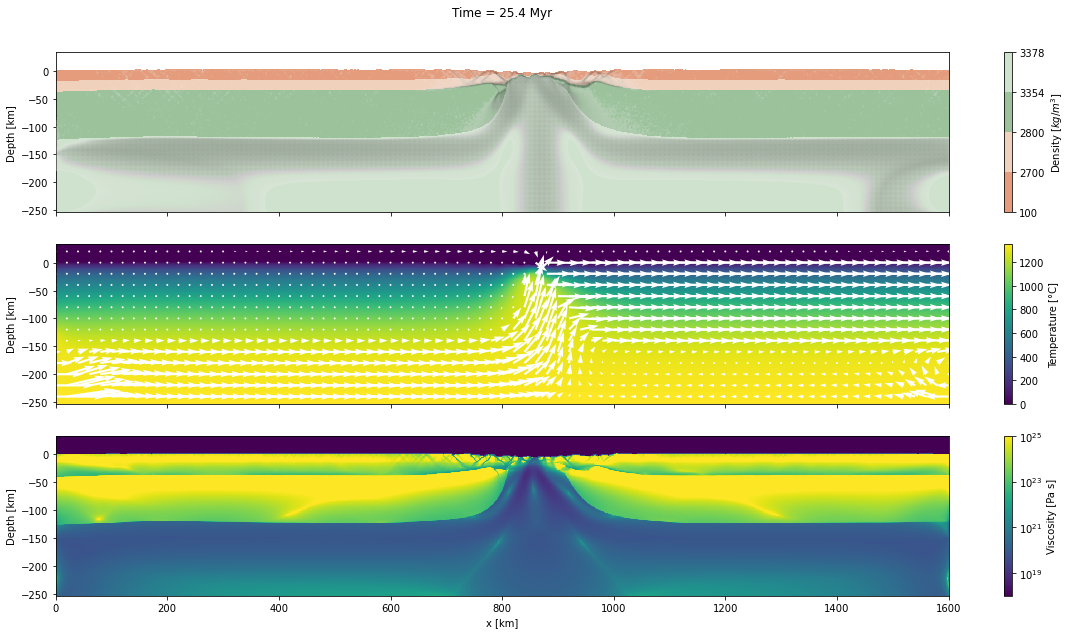

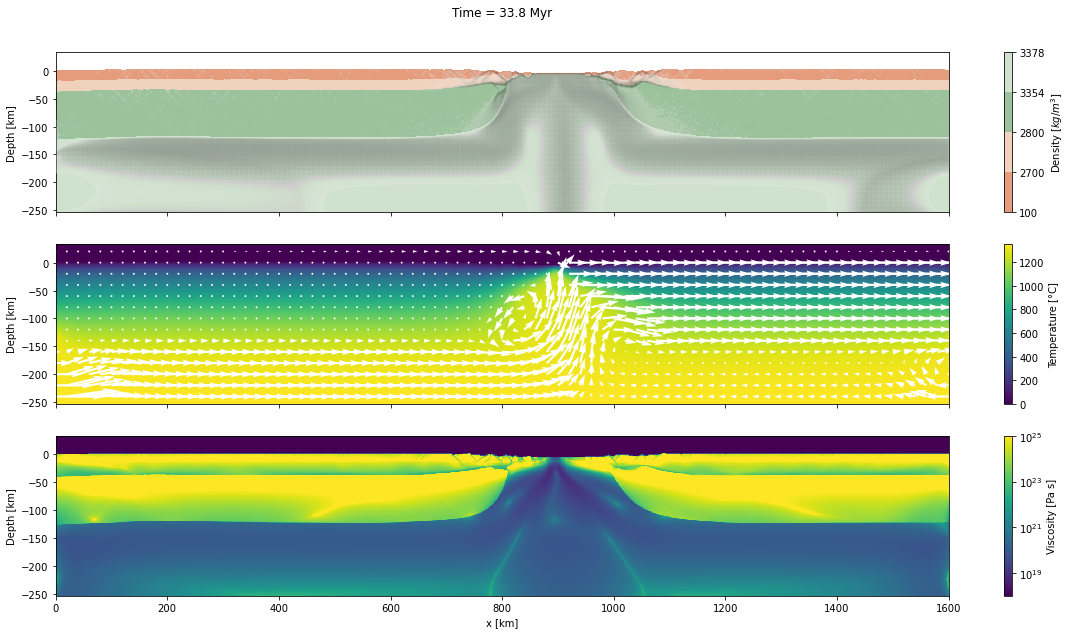

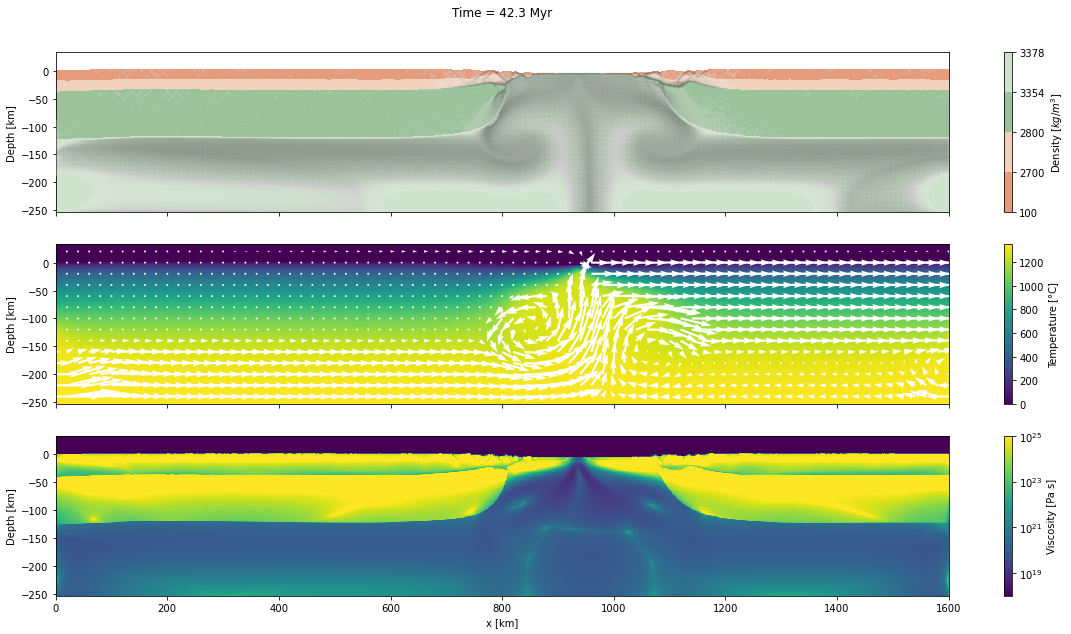

In [70]:
for cont in range(step_initial, step_final + d_step, d_step):  
    
    # Read the files:
    # Time
    filename = "output/time_" + str(cont) + ".txt"
    time = load_time(filename)
    # Density
    filename = "output/density_" + str(cont) + ".txt"
    rho = load_data(filename, nx, nz)    
    # Strain
    filename = "output/strain_" + str(cont) + ".txt"
    strain = load_data(filename, nx, nz)    
    strain[rho < 200] = 0
    strain_log = np.log10(strain)
    # Temperature
    filename = "output/temperature_" + str(cont) + ".txt"
    temp = load_data(filename, nx, nz)    
    # Velocity
    filename = "output/velocity_" + str(cont) + ".txt"
    veloc_x, veloc_z = load_velocity(filename, nx, nz)
    # Density
    filename = "output/viscosity_" + str(cont) + ".txt"
    visco = load_data(filename, nx, nz)
    visco_log = np.log10(visco)
    visco_log[visco_log == -np.inf] = 0
    
    
    # Create the plots:
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
    axs[0].set_title("Time = %.1lf Myr\n\n" % (time[0]/1.0e6))
      
    # Plot density and strain_log
    # Density
    img_rho = axs[0].contourf(
        xx/1e3,
        (zz + h_sair)/1e3,
        rho,
        levels=[100, 2700, 2800, 3354, 3378],
        colors=colors,
    )
    plt.colorbar(
        img_rho, 
        ax=axs[0], 
        orientation="vertical", 
        label="Density [$kg/m^3$]"
    )
    # Strain_log
    strain_aux = strain_log.copy()
    strain_aux[strain_aux == -np.Inf] = np.nan
    strain_aux[strain_aux < -0.5] = np.nan
    strain_aux[strain_aux > 0.9] = np.nan
    img_strain = axs[0].scatter(
        xx/1e3,
        (zz + h_sair)/1e3,
        c=strain_aux,
        zorder=100,
        s=0.5,
        alpha=0.05,
        cmap=plt.get_cmap("Greys"),
        vmin=-0.5,
        vmax=0.9,
    )
    axs[0].axis('equal')
    axs[0].set_ylabel("Depth [km]")

    # Plot temperature and velocity
    # Temperature
    img_temp = axs[1].pcolormesh(
        xx/1e3,
        (zz+h_sair)/1e3,
        temp,
        cmap="viridis", 
    )
    plt.colorbar(
        img_temp, 
        ax=axs[1],
        orientation="vertical", 
        label="Temperature [°C]"
    )
    # Velocity
    axs[1].quiver(
        xx[::20, ::20]/1e3, 
        (zz[::20, ::20] + h_sair)/1e3,
        (veloc_x[::20, ::20]/1e3).T,
        (veloc_z[::20, ::20]).T/1e3,
        color="w"
    ) 
    axs[1].axis('equal')
    axs[1].set_ylabel("Depth [km]")
    
    # Plot viscosity
    img_visco = axs[2].pcolormesh(
        xx/1e3,
        (zz+h_sair)/1e3,
        visco,
        cmap="viridis", 
        norm=LogNorm(),
        ) 
    plt.colorbar(
        img_visco,
        ax=axs[2],
        orientation="vertical",
        label="Viscosity [Pa s]"
    )
    axs[2].axis('equal')
    axs[2].set_ylabel("Depth [km]")
    axs[2].set_xlabel("x [km]")
    
    plt.show()  

<img src="continental-rift.gif" width="1800" align="center">